# Initializing and Reading Data

In [1]:
import pandas as pd
import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
import numpy as np
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error

/home/divij/anaconda3/envs/dsepi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# 2014
df_2014 = pd.read_csv("../../data/time_series/cleaned/TS_2014.csv")
df_2014['Issue Date'] = pd.to_datetime(df_2014['Issue Date'])
# 2015
df_2015 = pd.read_csv("../../data/time_series/cleaned/TS_2015.csv")
df_2015['Issue Date'] = pd.to_datetime(df_2015['Issue Date'])
# 2016
df_2016 = pd.read_csv("../../data/time_series/cleaned/TS_2016.csv")
df_2016['Issue Date'] = pd.to_datetime(df_2016['Issue Date'])
# 2017
df_2017 = pd.read_csv("../../data/time_series/cleaned/TS_2017.csv")
df_2017['Issue Date'] = pd.to_datetime(df_2017['Issue Date'])
# 2018
df_2018 = pd.read_csv("../../data/time_series/cleaned/TS_2018.csv")
df_2018['Issue Date'] = pd.to_datetime(df_2018['Issue Date'])
# 2019
df_2019 = pd.read_csv("../../data/time_series/cleaned/TS_2019.csv")
df_2019['Issue Date'] = pd.to_datetime(df_2019['Issue Date']) 
# 2020
df_2020 = pd.read_csv("../../data/time_series/cleaned/TS_2020.csv")
df_2020['Issue Date'] = pd.to_datetime(df_2020['Issue Date'])
# 2021
df_2021 = pd.read_csv("../../data/time_series/cleaned/TS_2021.csv")
df_2021['Issue Date'] = pd.to_datetime(df_2021['Issue Date'])
# 2022
df_2022 = pd.read_csv("../../data/time_series/cleaned/TS_2022.csv")
df_2022['Issue Date'] = pd.to_datetime(df_2022['Issue Date'])
# 2023
df_2023 = pd.read_csv("../../data/time_series/cleaned/TS_2023.csv")
df_2023['Issue Date'] = pd.to_datetime(df_2023['Issue Date'])

# Combining Data

In [3]:
# Check Data Type
df_2023.dtypes

Issue Date            datetime64[ns]
Violation Precinct             int64
Counts                         int64
dtype: object

In [4]:
final_df = pd.concat([df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], axis = 0)
final_df = final_df.reset_index(drop = True)

In [5]:
final_df = final_df[final_df["Violation Precinct"] == 5].reset_index(drop = True)
final_df = final_df.drop(columns=["Violation Precinct"])
final_df

,Issue Date,Counts
0,2013-07-02,0
1,2013-07-03,0
2,2013-07-04,1
3,2013-07-06,0
4,2013-07-07,0
...,...,...
3620,2023-06-26,2
3621,2023-06-27,0
3622,2023-06-28,2
3623,2023-06-29,0


# Fitting and Predicting

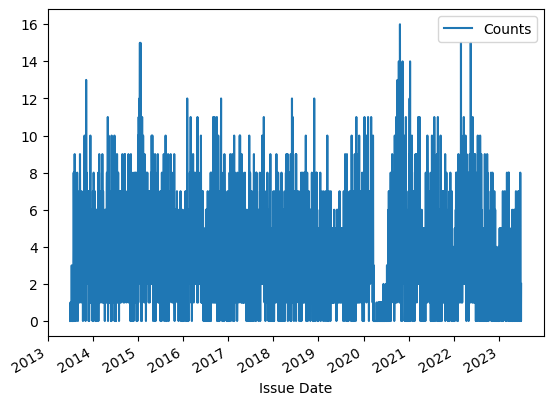

In [6]:
final_df.plot(x = "Issue Date", y = "Counts")
mpl.pyplot.show()

<Axes: xlabel='Issue Date'>

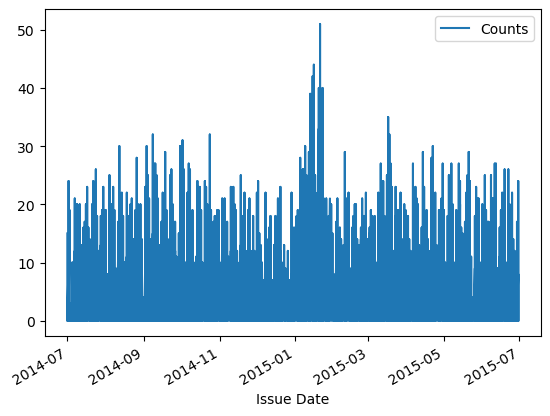

In [7]:
df_2015.plot(y = "Counts", x = "Issue Date")

The time series fluctuates a lot day to day, so it might be harder to model. We should check:

### Augmented Dickey-Fuller Test

For stationarity:

In [8]:
result = adfuller(final_df['Counts'])
print("p-value", result[1])

p-value 7.598483680278143e-09


This suggests that the time series is stationary.

<Axes: >

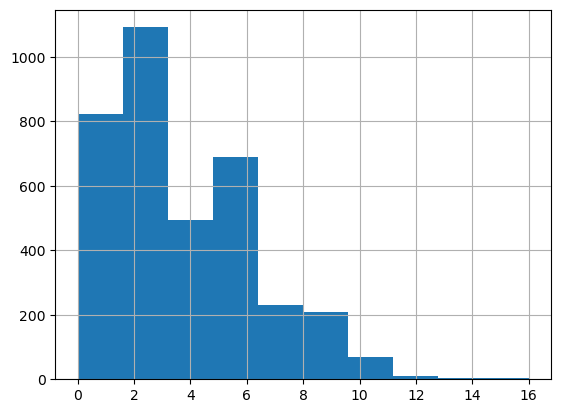

In [9]:
final_df["Counts"].hist()

It is not normally distributed. We can either try scaling, or we can also use daily percentage change.

## Percentage Change

In [10]:
change_df = final_df.set_index("Issue Date")
change_df = change_df.pct_change()
change_df.head()

,Counts
Issue Date,
2013-07-02,NaN
2013-07-03,NaN
2013-07-04,inf
2013-07-06,-1.0
2013-07-07,NaN


<Axes: xlabel='Issue Date'>

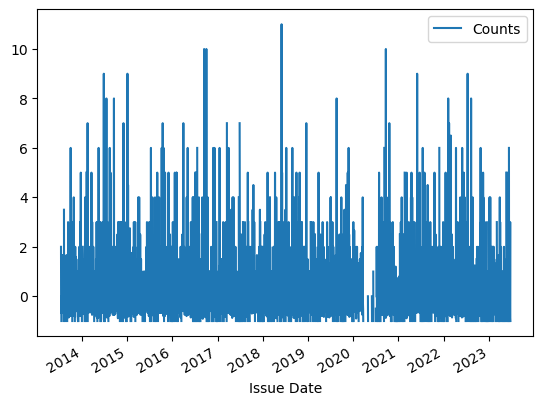

In [11]:
change_df.plot()

We can see here that there are some massive outliers in our data that prevent us from using it to do time series modeling. Interestingly, from this visualization, we can also see that these seem to happen once every year. Let's see when these happen:

In [12]:
outlier_list = np.where(change_df['Counts']>100)[0]
outlier_list

array([   2,    8,   10,   22,   26,   34,   47,   62,  103,  124,  149,
        153,  181,  183,  186,  204,  215,  228,  280,  306,  331,  334,
        359,  364,  366,  391,  484,  486,  498,  509,  534,  540,  570,
        576,  609,  667,  681,  687,  727,  729,  736,  757,  772,  778,
        793,  841,  873,  891,  901,  905,  909,  917,  934,  946,  953,
        981, 1075, 1078, 1086, 1090, 1097, 1104, 1112, 1121, 1126, 1132,
       1182, 1188, 1195, 1202, 1223, 1230, 1240, 1260, 1266, 1269, 1273,
       1279, 1293, 1311, 1321, 1344, 1420, 1433, 1440, 1447, 1450, 1454,
       1466, 1472, 1487, 1495, 1515, 1529, 1571, 1596, 1606, 1612, 1617,
       1627, 1633, 1635, 1638, 1641, 1676, 1684, 1690, 1703, 1711, 1725,
       1727, 1753, 1774, 1780, 1802, 1815, 1840, 1854, 1859, 1898, 1910,
       1931, 1952, 1959, 1972, 1989, 1996, 2015, 2036, 2050, 2064, 2075,
       2078, 2093, 2142, 2192, 2206, 2223, 2226, 2235, 2255, 2266, 2271,
       2276, 2279, 2293, 2349, 2353, 2360, 2400, 24

In [13]:
change_df.iloc[3285]

Counts    0.333333
Name: 2022-07-26 00:00:00, dtype: float64

In [14]:
change_df.iloc[2920]

Counts   -1.0
Name: 2021-07-25 00:00:00, dtype: float64

These seem to happen yearly on the 1st of July, which is also when each of our yearly datasets start. This suggests a filing or data recording issue most likely, and should definitely be looked into on a systematic level as to why this is happening year-after-year. 

For our model, we should try to remove these from the original `final_df` and then recalculate our `change_df`.

<Axes: xlabel='Issue Date'>

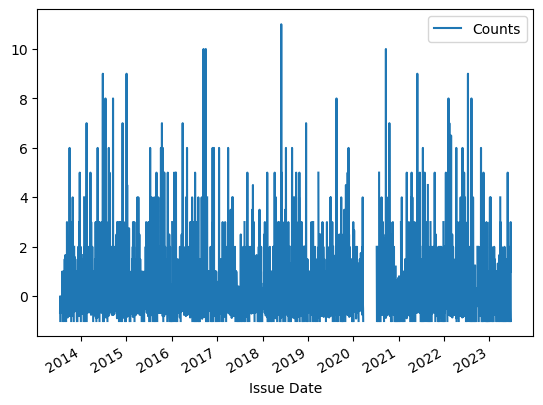

In [15]:
final_df.drop(index=outlier_list, inplace=True)
change_df = final_df.set_index("Issue Date")
change_df = change_df.pct_change()
change_df.plot()

In [16]:
outlier_list = np.where(change_df['Counts']>100)[0]
outlier_list

array([   8,   22,   29,   41,   55,   95,  115,  139,  142,  172,  189,
        199,  211,  262,  287,  311,  313,  337,  342,  366,  459,  470,
        480,  504,  509,  538,  543,  575,  632,  645,  650,  690,  696,
        716,  730,  735,  749,  796,  827,  844,  853,  856,  859,  866,
        882,  893,  899,  926, 1019, 1021, 1028, 1031, 1037, 1043, 1050,
       1058, 1062, 1067, 1116, 1121, 1127, 1133, 1153, 1159, 1168, 1187,
       1192, 1197, 1202, 1215, 1232, 1241, 1263, 1338, 1350, 1356, 1362,
       1364, 1367, 1378, 1383, 1397, 1404, 1423, 1436, 1477, 1501, 1510,
       1515, 1519, 1528, 1534, 1536, 1538, 1572, 1579, 1584, 1596, 1603,
       1617, 1642, 1662, 1667, 1688, 1700, 1724, 1737, 1741, 1779, 1790,
       1810, 1830, 1836, 1848, 1864, 1870, 1888, 1908, 1921, 1934, 1944,
       1946, 1960, 2008, 2057, 2070, 2086, 2088, 2096, 2115, 2125, 2129,
       2133, 2135, 2148, 2203, 2206, 2212, 2251, 2321, 2345, 2355, 2368,
       2373, 2378, 2385, 2389, 2398, 2402, 2429, 24

In [17]:
change_df.iloc[3120]

Counts    inf
Name: 2022-09-27 00:00:00, dtype: float64

Now, the outliers have moved, but still happen at the boundary of when a yearly dataset meets a new one. We can look at this boundary closer.

In [18]:
checking_df = pd.concat([df_2016, df_2017], axis = 0)

In [19]:
checking_df = checking_df[checking_df["Violation Precinct"] == 5].reset_index(drop=True)
checking_df = checking_df.drop(columns=["Violation Precinct"])

In [20]:
display(checking_df)

,Issue Date,Counts
0,2015-07-01,7
1,2015-07-02,3
2,2015-07-03,0
3,2015-07-04,1
4,2015-07-05,0
...,...,...
721,2017-06-24,5
722,2017-06-25,0
723,2017-06-26,1
724,2017-06-27,8


<Axes: xlabel='Issue Date'>

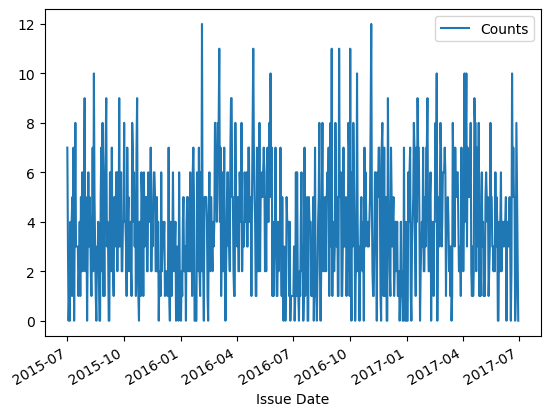

In [21]:
checking_df.plot(x = 'Issue Date', y = 'Counts')

From this graph, we can see why the percentage change seem huge! It's because NYC parking violation tickets seem to go down quite a lot by the time the end of the recording year comes around (i.e., the month of June). 

However, this answer does not help our modeling - we will have to use the non-normal counts data, and not the percentage (technically, fractional) change data.

## ARIMA Model

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
final_df = pd.concat([df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023], axis = 0)
final_df = final_df.reset_index(drop = True)

In [23]:
final_df = final_df[final_df["Violation Precinct"] == 5].reset_index(drop = True)
final_df = final_df.drop(columns=["Violation Precinct"])
final_df

,Issue Date,Counts
0,2013-07-02,0
1,2013-07-03,0
2,2013-07-04,1
3,2013-07-06,0
4,2013-07-07,0
...,...,...
3620,2023-06-26,2
3621,2023-06-27,0
3622,2023-06-28,2
3623,2023-06-29,0


#### Parameter Selection

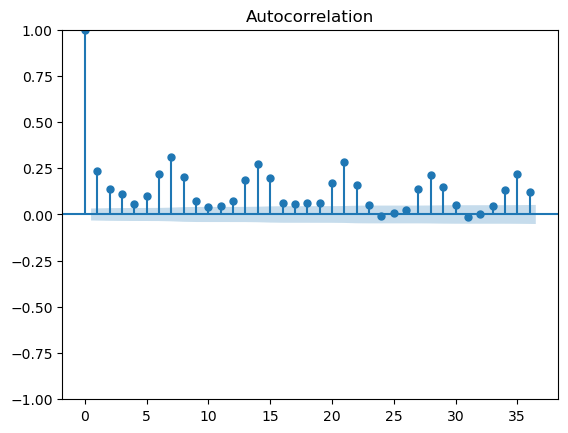

In [24]:
arima_df = final_df.set_index("Issue Date")
plot_acf(arima_df.Counts);

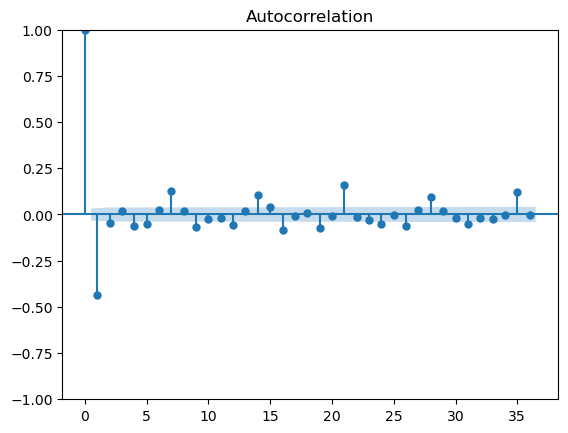

In [25]:
arima_df_d1 = arima_df.diff().dropna()
plot_acf(arima_df_d1.Counts);

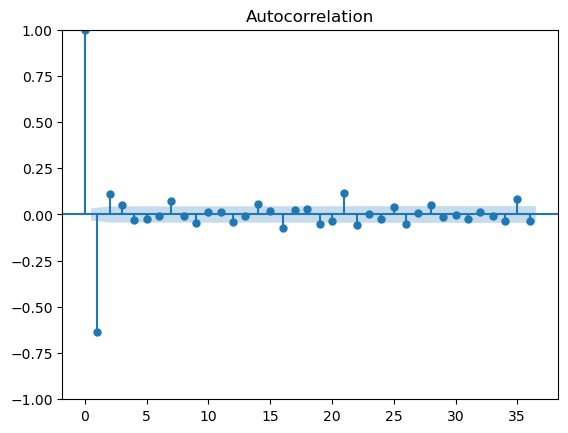

In [26]:
arima_df_d2 = arima_df_d1.diff().dropna()
plot_acf(arima_df_d2.Counts);

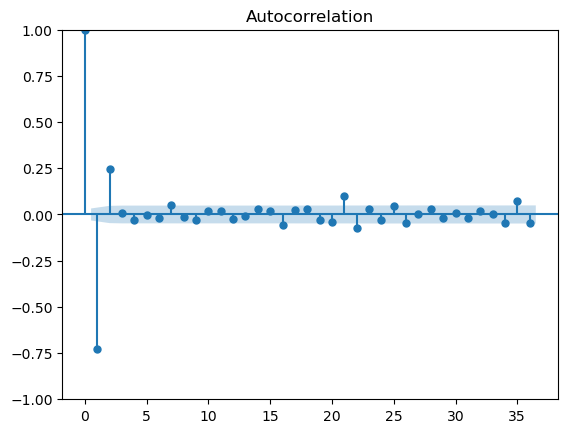

In [27]:
arima_df_d3 = arima_df_d2.diff().dropna()
plot_acf(arima_df_d3.Counts);

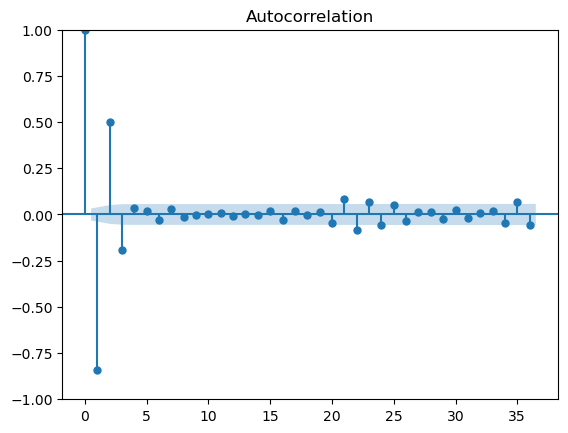

In [28]:
arima_df_d7 = arima_df_d3.diff().diff().diff().dropna()
plot_acf(arima_df_d7);

Usually, differencing once or twice is common and should result in much lower autocorrelations. Similarly hard will be to find values of $p$ and $q$ for our ARIMA model. So, we can use hyper parameter tuning.

#### Hyper Parameter Tuning

In [29]:
# Load the data and split it into separate pieces
data = np.array(final_df['Counts'])
train, test = model_selection.train_test_split(data, train_size=3285)

# Fit a simple auto_arima model
modl = pm.auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')

# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

Test RMSE: 2.302


## Prophet Model

In [31]:
m = Prophet()
train_prophet, test_prophet = model_selection.train_test_split(final_df, train_size = 3285)
train_prophet['ds'] = train_prophet['Issue Date']
train_prophet['y'] = train_prophet['Counts']
m.fit(train_prophet)
# future = m.make_future_dataframe(periods=365, include_history = False)
future = m.make_future_dataframe(periods=340, include_history = False)
forecast = m.predict(future)
preds_prophet = np.array(forecast[['yhat']])
test_prophet = np.array(test_prophet['Counts'])
# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test_prophet, preds_prophet)))

15:32:57 - cmdstanpy - INFO - Chain [1] start processing
15:32:57 - cmdstanpy - INFO - Chain [1] done processing


Test RMSE: 2.814


# Conclusion

Both our models give very similar RMSE. So we will be plotting both! But before that, we should clean up our data. There is a huge random spike in January 2015, and a surprisingly deep trough in Mar-July of 2020 (likely due to COVID-19). Let's clean this.

In [32]:
cleaned_final_df1 = final_df.drop(final_df[(final_df['Issue Date'] >= '2015-01-01') & (final_df['Issue Date'] <= '2015-02-01')].index)
display(cleaned_final_df1)
cleaned_final_df = cleaned_final_df1.drop(cleaned_final_df1[(cleaned_final_df1['Issue Date'] >= '2020-03-01') & (cleaned_final_df1['Issue Date'] <= '2020-07-01')].index)
display(cleaned_final_df)

,Issue Date,Counts
0,2013-07-02,0
1,2013-07-03,0
2,2013-07-04,1
3,2013-07-06,0
4,2013-07-07,0
...,...,...
3620,2023-06-26,2
3621,2023-06-27,0
3622,2023-06-28,2
3623,2023-06-29,0


,Issue Date,Counts
0,2013-07-02,0
1,2013-07-03,0
2,2013-07-04,1
3,2013-07-06,0
4,2013-07-07,0
...,...,...
3620,2023-06-26,2
3621,2023-06-27,0
3622,2023-06-28,2
3623,2023-06-29,0


In [33]:
final_df = cleaned_final_df

In [35]:
data_arima = np.array(final_df['Counts'])
modl = pm.auto_arima(data_arima, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')
preds_arima = modl.predict(n_periods=test.shape[0], return_conf_int=False)

In [36]:
fitted_vals_arima = modl.fittedvalues()
# len(fitted_vals_arima + preds_arima)
result = np.concatenate((fitted_vals_arima, preds_arima), axis=0)

In [37]:
result_df_arima = pd.DataFrame(result)

In [38]:
display(result_df_arima)

,0
0,3.680318
1,2.922863
2,2.666073
3,2.795820
4,2.602605
...,...
3810,3.651100
3811,3.633730
3812,3.620088
3813,3.620566


In [39]:
m = Prophet()
data_prophet = final_df
data_prophet['ds'] = final_df['Issue Date']
data_prophet['y'] = final_df['Counts']
m.fit(data_prophet)
future = m.make_future_dataframe(periods=365, include_history = True)
forecast = m.predict(future)
preds_prophet = forecast[["ds","yhat"]]

15:36:05 - cmdstanpy - INFO - Chain [1] start processing


15:36:05 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
preds_prophet

,ds,yhat
0,2013-07-02,3.367624
1,2013-07-03,3.406012
2,2013-07-04,3.531575
3,2013-07-06,2.454804
4,2013-07-07,0.548246
...,...,...
3835,2024-06-25,2.422828
3836,2024-06-26,2.421448
3837,2024-06-27,2.504844
3838,2024-06-28,2.365977


In [41]:
output = preds_prophet
output = output.rename(columns = {"ds":"time", "yhat":"prophet_pred"})
output = pd.merge(output, result_df_arima, how='inner', left_index=True, right_index=True)
prep_final_df = final_df
prep_final_df = prep_final_df.rename(columns = {"Issue Date":"time"})
output = output.merge(prep_final_df, how = "outer", on = "time")
output = output.drop(columns = ["ds", "y"])
output = output.rename(columns = {"Counts": "values", 0:"arima_pred"})

In [42]:
display(output)

,time,prophet_pred,arima_pred,values
0,2013-07-02,3.367624,3.680318,0.0
1,2013-07-03,3.406012,2.922863,0.0
2,2013-07-04,3.531575,2.666073,1.0
3,2013-07-06,2.454804,2.795820,0.0
4,2013-07-07,0.548246,2.602605,0.0
...,...,...,...,...
3810,2024-05-31,3.352973,3.651100,NaN
3811,2024-06-01,2.372864,3.633730,NaN
3812,2024-06-02,0.460652,3.620088,NaN
3813,2024-06-03,2.229323,3.620566,NaN


In [43]:
# output.to_csv("../../data/time_series/line_graph_data.csv")

For better visualization, let convert this to only monthly data

In [44]:
output.set_index('time', inplace=True)
output_monthly = output.resample('MS').sum()

In [45]:
display(output_monthly)

,prophet_pred,arima_pred,values
time,,,
2013-07-01,89.582174,49.814375,26.0
2013-08-01,110.583126,80.990881,104.0
2013-09-01,111.461431,101.304029,111.0
2013-10-01,121.088214,113.882558,112.0
2013-11-01,110.340907,120.923156,131.0
...,...,...,...
2024-02-01,80.998735,103.231226,0.0
2024-03-01,87.898184,111.236820,0.0
2024-04-01,84.255807,108.362950,0.0


In [46]:
output_monthly.reset_index(inplace=True)

In [47]:
display(output_monthly)

,time,prophet_pred,arima_pred,values
0,2013-07-01,89.582174,49.814375,26.0
1,2013-08-01,110.583126,80.990881,104.0
2,2013-09-01,111.461431,101.304029,111.0
3,2013-10-01,121.088214,113.882558,112.0
4,2013-11-01,110.340907,120.923156,131.0
...,...,...,...,...
127,2024-02-01,80.998735,103.231226,0.0
128,2024-03-01,87.898184,111.236820,0.0
129,2024-04-01,84.255807,108.362950,0.0
130,2024-05-01,85.181338,112.610110,0.0


In [48]:
# output_monthly.to_csv("../../data/time_series/line_graph_monthly_data.csv")